In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime as dt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Loading clean datasets for 2017-2019

In [2]:
df1 = pd.read_csv("/Users/stephan/Data_Science/Metis/Bootcamp/data_2017_clean.csv")
df2 = pd.read_csv("/Users/stephan/Data_Science/Metis/Bootcamp/data_2018_clean.csv")
df3 = pd.read_csv("/Users/stephan/Data_Science/Metis/Bootcamp/data_2019_clean.csv")
data = pd.concat([df1,df2,df3])
data.drop(columns="Unnamed: 0", inplace=True)
data["DATE"] = pd.to_datetime(data["DATE"])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5511003 entries, 0 to 1833809
Data columns (total 6 columns):
 #   Column   Dtype         
---  ------   -----         
 0   STATION  object        
 1   ID       object        
 2   DATE     datetime64[ns]
 3   ENTRIES  float64       
 4   EXITS    float64       
 5   TRAFFIC  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 294.3+ MB


In [4]:
data.describe()

,ENTRIES,EXITS,TRAFFIC
count,5.510942e+06,5.510942e+06,5.510942e+06
mean,1.544081e+03,1.544081e+03,3.088161e+03
std,5.123809e+03,5.123809e+03,1.024762e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.059162e+02,3.059162e+02,6.118323e+02
50%,8.500000e+02,8.500000e+02,1.700000e+03
75%,1.619653e+03,1.619653e+03,3.239305e+03
max,8.639900e+04,8.639900e+04,1.727980e+05


For this analysis we are not interested in data for single turnstiles. In our design we are aiming to give a recommendation by station, so we are grouping the data that way and summing up individual turnstile data

In [5]:
traffic_by_station = data.groupby(['STATION','DATE'], as_index=False)['TRAFFIC'].sum()
# Numbers become very large, so dividing by 1000000 to look at millions of people travelling through stations
traffic_by_station["TRAFFIC"] = traffic_by_station.TRAFFIC.astype(int)/1000000

In [6]:
total_traffic_monthly = traffic_by_station.groupby([traffic_by_station.DATE.dt.year.rename('year'), 
                                                    traffic_by_station.DATE.dt.month.rename('month')]).sum()

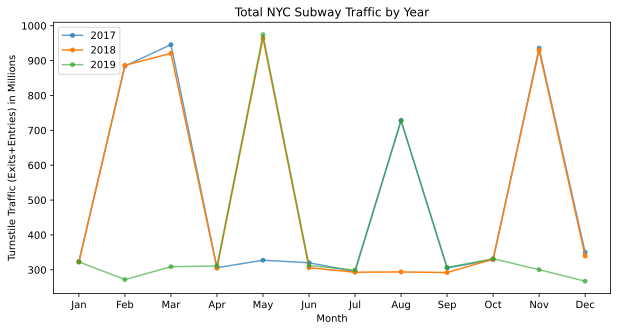

In [7]:
plt.figure(figsize=(10,5))
plt.plot(total_traffic_monthly.loc[2017].index,total_traffic_monthly.loc[2017].TRAFFIC, marker='o', markersize=4, alpha=0.7)
plt.plot(total_traffic_monthly.loc[2018].index,total_traffic_monthly.loc[2018].TRAFFIC, marker='o', markersize=4)
plt.plot(total_traffic_monthly.loc[2019].index,total_traffic_monthly.loc[2019].TRAFFIC, marker='o', markersize=4, alpha=0.6)
plt.title('Total NYC Subway Traffic by Year')
plt.xlabel('Month')
plt.xticks(np.arange(1,13,1), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('Turnstile Traffic (Exits+Entries) in Millions')
plt.legend([2017,2018,2019]);

Given that the gala is in early summer, seeing a large increase in traffic in May makes us look into that month a little further

In [8]:
traffic_may = traffic_by_station[traffic_by_station.DATE.dt.month == 5]
traffic_weekly_may = traffic_may.groupby([traffic_may.DATE.dt.year.rename('year'),
                                          traffic_may.DATE.dt.week.rename('week'),
                                          traffic_may.DATE.dt.day.rename('day'), 'DATE']).sum()
traffic_weekly_may.reset_index(inplace=True)

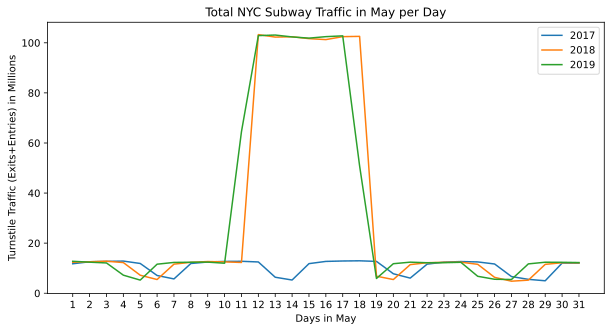

In [9]:
plt.figure(figsize=(10,5))
plt.plot(traffic_weekly_may.query('year == 2017')['day'], traffic_weekly_may.query('year == 2017')['TRAFFIC'])
plt.plot(traffic_weekly_may.query('year == 2018')['day'], traffic_weekly_may.query('year == 2018')['TRAFFIC'])
plt.plot(traffic_weekly_may.query('year == 2019')['day'], traffic_weekly_may.query('year == 2019')['TRAFFIC'])
plt.title('Total NYC Subway Traffic in May per Day')
plt.xlabel('Days in May')
plt.xticks(np.arange(1,32,1))
plt.ylabel('Turnstile Traffic (Exits+Entries) in Millions')
plt.legend([2017,2018,2019]);

We are also interested in trends for the days of the week so we can recommend whether to canvas during the week or in weekends, so looking at May specifically, we plot the traffic per day of the week for May 2019

In [10]:
May_2019 = traffic_weekly_may.loc[traffic_weekly_may.year==2019]
May_2019['day_of_week'] = May_2019.DATE.dt.dayofweek
May_2018 = traffic_weekly_may.loc[traffic_weekly_may.year==2018]
May_2018['day_of_week'] = May_2018.DATE.dt.dayofweek

<ipython-input-10-df1f8151fd6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  May_2019['day_of_week'] = May_2019.DATE.dt.dayofweek
<ipython-input-10-df1f8151fd6e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  May_2018['day_of_week'] = May_2018.DATE.dt.dayofweek


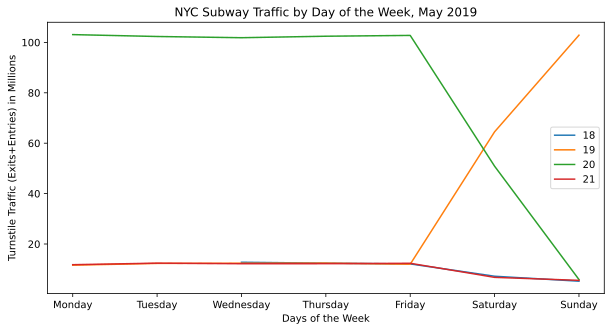

In [11]:
weeks = [18,19,20,21]

plt.figure(figsize=(10,5))
for wk in weeks:
    mask = May_2019['week'] == wk
    plt.plot(May_2019.loc[mask,'day_of_week'], May_2019.loc[mask,'TRAFFIC'], label = wk)

plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Days of the Week')
plt.title('NYC Subway Traffic by Day of the Week, May 2019')
plt.ylabel('Turnstile Traffic (Exits+Entries) in Millions')
plt.legend();

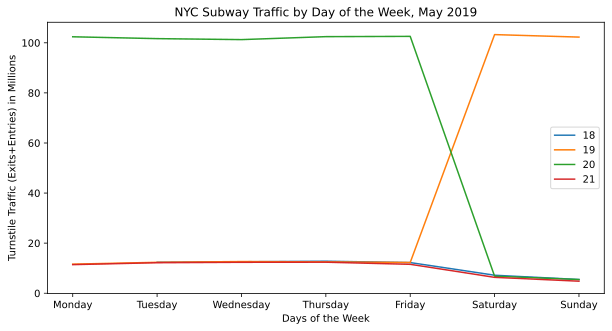

In [12]:
plt.figure(figsize=(10,5))
for wk in weeks:
    mask = May_2018['week'] == wk
    plt.plot(May_2018.loc[mask,'day_of_week'], May_2018.loc[mask,'TRAFFIC'], label = wk)

plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Days of the Week')
plt.title('NYC Subway Traffic by Day of the Week, May 2019')
plt.ylabel('Turnstile Traffic (Exits+Entries) in Millions')
plt.legend();